In [69]:
import numpy as np
import matplotlib.pyplot as plt

from lab2_proto import *
from lab2_tools import *

from prondict import *

In [70]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']

In [71]:
phoneHMMs_one = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

In [72]:
isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']

In [73]:
wordHMMs_one = {}
wordHMMs_all = {}

for digit in prondict.keys():
    wordHMMs_one[digit] = concatHMMs(phoneHMMs_one, isolated[digit])
    wordHMMs_all[digit] = concatHMMs(phoneHMMs_all, isolated[digit])


In [74]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
list(example.keys())

['filename',
 'samplingrate',
 'gender',
 'speaker',
 'digit',
 'repetition',
 'samples',
 'lmfcc',
 'obsloglik',
 'logalpha',
 'loglik',
 'vloglik',
 'vpath',
 'logbeta',
 'loggamma']

## 5.1 Gaussian emission probabilities

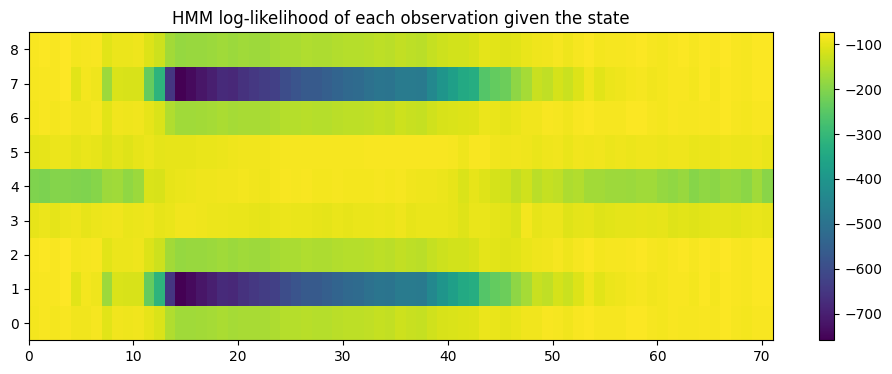

In [75]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs_one['o']['means'], wordHMMs_one['o']['covars'])

plt.figure(figsize=(12, 4))
plt.pcolormesh(obsloglik.T)
plt.colorbar()
plt.title("HMM log-likelihood of each observation given the state")
plt.yticks(np.arange(9) + 0.5, np.arange(9))

assert np.allclose(obsloglik, example['obsloglik'])

Plot the log likelihood for Gaussians from HMMs models corresponding to the same digit on
a test utterance of your choice. What can you say about the figure? Which Gaussian components
give the high likelihood in which time steps? Why? Remember that each utterance starts and
ends with silence.

In [76]:
isolated

{'o': ['sil', 'ow', 'sil'],
 'z': ['sil', 'z', 'iy', 'r', 'ow', 'sil'],
 '1': ['sil', 'w', 'ah', 'n', 'sil'],
 '2': ['sil', 't', 'uw', 'sil'],
 '3': ['sil', 'th', 'r', 'iy', 'sil'],
 '4': ['sil', 'f', 'ao', 'r', 'sil'],
 '5': ['sil', 'f', 'ay', 'v', 'sil'],
 '6': ['sil', 's', 'ih', 'k', 's', 'sil'],
 '7': ['sil', 's', 'eh', 'v', 'ah', 'n', 'sil'],
 '8': ['sil', 'ey', 't', 'sil'],
 '9': ['sil', 'n', 'ay', 'n', 'sil']}

In [77]:
test_utterance = data[10]
test_utterance["digit"]

'4'

In [78]:
isolated["4"]

['sil', 'f', 'ao', 'r', 'sil']

Text(0.5, 1.0, 'HMM log-likelihood of each observation given the state (all speakers)')

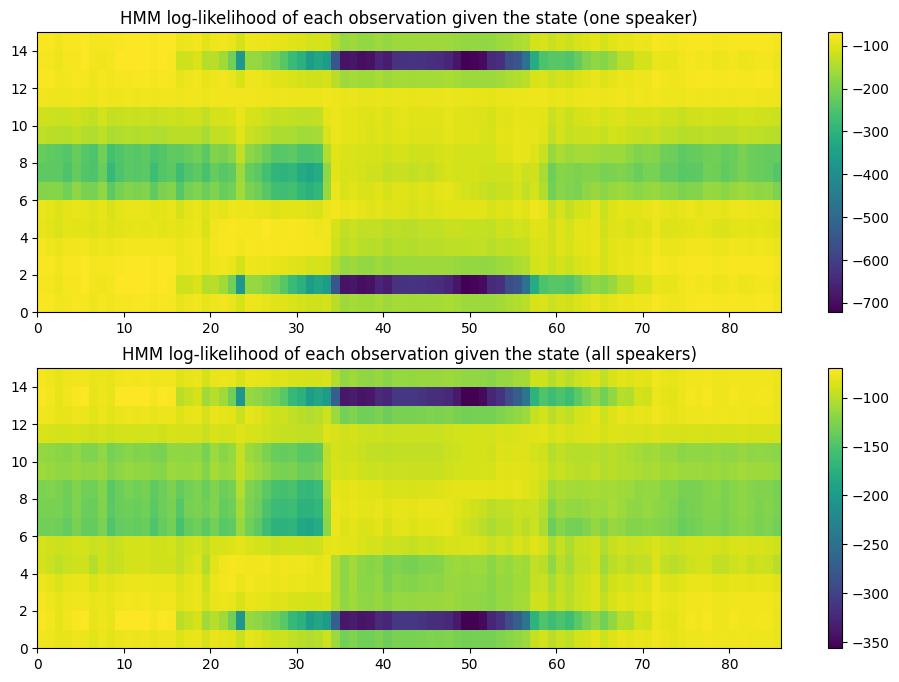

In [79]:
HMM_one = wordHMMs_one[test_utterance['digit']]
HMM_all = wordHMMs_all[test_utterance['digit']]

obsloglik_one = log_multivariate_normal_density_diag(test_utterance['lmfcc'], HMM_one['means'], HMM_one['covars'])
obsloglik_all = log_multivariate_normal_density_diag(test_utterance['lmfcc'], HMM_all['means'], HMM_all['covars'])

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.pcolormesh(obsloglik_one.T)
plt.colorbar()
plt.title("HMM log-likelihood of each observation given the state (one speaker)")

plt.subplot(2, 1, 2)
plt.pcolormesh(obsloglik_all.T)
plt.colorbar()
plt.title("HMM log-likelihood of each observation given the state (all speakers)")

*Answer:*
Here, the observed digit is 4, which is a concatenation of 5 phonemes : ['sil', 'f', 'ao', 'r', 'sil']. The HMM model is a concatenation of 15 states (the y-axis of the figures).
We can see a block diagonal structure moving from left to right, which matches the progression of the utterance. So the gaussian components for the silence give high likelihood at the beginning and end of the word (0-15 and 70-85) for example.
The silence phoneme has a higher likelihood than 'ao' and 'r', because it's more distinct.

The figure with all speakers have likelihoods that are less high, which shows the variability accross speakers. However, its minimum is also higher than the figure with the sole speaker, so it will perform more uniformly and less confidently accross multiple speakers.

Basically, the model recognized the phonomes states correctly. 

## 5.2 Forward algorithm

C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\3920808951.py:1: RuntimeWarning: divide by zero encountered in log
  log_alpha = forward(obsloglik, np.log(wordHMMs_one['o']['startprob'])[:-1], np.log(wordHMMs_one['o']['transmat'][:-1, :-1]))


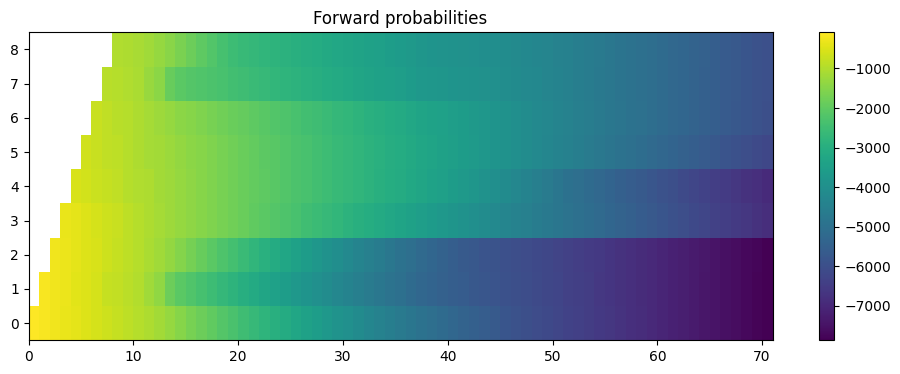

In [80]:
log_alpha = forward(obsloglik, np.log(wordHMMs_one['o']['startprob'])[:-1], np.log(wordHMMs_one['o']['transmat'][:-1, :-1]))

plt.figure(figsize=(12, 4))
plt.pcolormesh(log_alpha.T)
plt.colorbar()
plt.yticks(np.arange(9) + 0.5, np.arange(9))
plt.title("Forward probabilities")

assert np.allclose(log_alpha, example['logalpha'])

In [81]:
def sequence_likelihood_forward(log_alpha):
    """
    Compute the sequence likelihood given the forward probabilities (log_alpha),
    """
    return logsumexp(log_alpha[-1, :])


loglik_forward = sequence_likelihood_forward(log_alpha)
example['loglik'], loglik_forward

(-5970.427602563561, -5970.427602563563)

*Answer:* The loglikelihood of the sequence is the log of the sum of the alpha probabilities of the final time step, over all the states.

Using your formula, score all the 44 utterances in the data array with each of the 11 HMM
models in wordHMMs. Do you see any mistakes if you take the maximum likelihood model as
winner? Compare the results obtained from the models trained on a single speaker or all the
training speakers.

In [82]:
from tqdm import tqdm


def score_utterrances(data, wordHMMs):
    """
    Compute the log-likelihood of each utterance in data given the wordHMMs.
    """
    scores = []
    for i in tqdm(range(len(data))):
        for h in wordHMMs.keys():
            obsloglik = log_multivariate_normal_density_diag(data[i]['lmfcc'], wordHMMs[h]['means'], wordHMMs[h]['covars'])
            log_alpha = forward(obsloglik, np.log(wordHMMs[h]['startprob'])[:-1], np.log(wordHMMs[h]['transmat'][:-1, :-1]))
            scores.append(sequence_likelihood_forward(log_alpha))
    return np.array(scores).reshape(len(data), len(wordHMMs))

lik_all = score_utterrances(data, wordHMMs_all)
lik_one = score_utterrances(data, wordHMMs_one)

  0%|          | 0/44 [00:00<?, ?it/s]C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\3616961128.py:12: RuntimeWarning: divide by zero encountered in log
  log_alpha = forward(obsloglik, np.log(wordHMMs[h]['startprob'])[:-1], np.log(wordHMMs[h]['transmat'][:-1, :-1]))
100%|██████████| 44/44 [00:44<00:00,  1.01s/it]


In [83]:
def max_lik_pred(lik, wordHMMs):
    """
    Predict the digit for each utterance in data using the maximum likelihood criterion.
    """
    pred = np.argmax(lik, axis=1)
    return [list(wordHMMs.keys())[i] for i in pred]

def accuracy(pred, data):
    """
    Compute the accuracy of the predictions.
    """
    defects = []
    correct = 0
    for i in range(len(data)):
        if pred[i] == data[i]['digit']:
            correct += 1
        else:
            defects.append((data[i]['digit'], pred[i]))
    return correct / len(data), defects

pred_all = max_lik_pred(lik_all, wordHMMs_all)
pred_one = max_lik_pred(lik_one, wordHMMs_one)

acc_all, defects_max_lik_all = accuracy(pred_all, data)
acc_one, defects_max_lik_one = accuracy(pred_one, data)

print(f"Accuracy (all speakers): {acc_all:.2f}")
print(f"Accuracy (one speaker): {acc_one:.2f}")

Accuracy (all speakers): 0.98
Accuracy (one speaker): 0.77


*Answer:* The models trained on a single speaker overfitted, while the models trained on all speakers see more varied acoustic patterns, so they are more robust to new speakers.

## 5.3 Viterbi Approximation

In [84]:
log_V, viterbi_path = viterbi(obsloglik, np.log(wordHMMs_one['o']['startprob'])[:-1], np.log(wordHMMs_one['o']['transmat'][:-1, :-1]), forceFinalState=True)
assert np.allclose(log_V, example['vloglik'])

C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\4013680231.py:1: RuntimeWarning: divide by zero encountered in log
  log_V, viterbi_path = viterbi(obsloglik, np.log(wordHMMs_one['o']['startprob'])[:-1], np.log(wordHMMs_one['o']['transmat'][:-1, :-1]), forceFinalState=True)


Text(0.5, 1.0, 'Alpha (forward) log posterior probabilities, with Viterbi path')

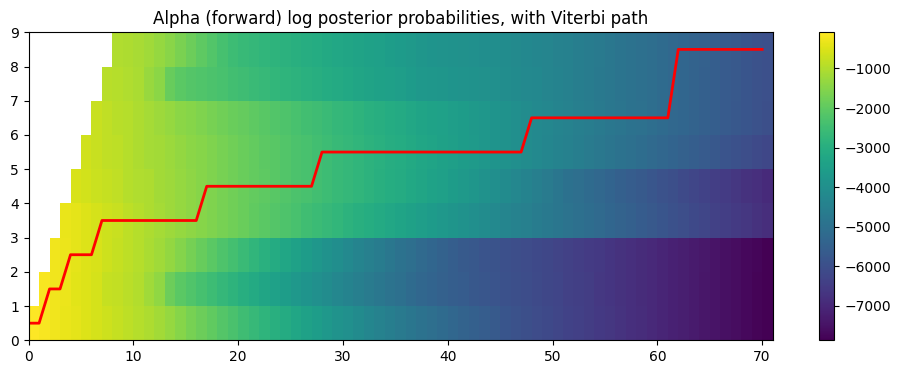

In [85]:
plt.figure(figsize=(12, 4))
plt.pcolormesh(log_alpha.T)
plt.colorbar()
plt.plot(viterbi_path+0.5, 'r', lw=2)
plt.title("Alpha (forward) log posterior probabilities, with Viterbi path")

*Answer:* The path looks this way because of how the state transitions are defined. It is possible to stay in the same state for a certain period of time, then it is only possible to forward the next state, it is not possible to go back, hence the stair like structure of the path. The path can only increase or stay the same along the y-axis.

In [86]:
def score_utterrances_viterbi(data, wordHMMs):
    """
    Compute the log-likelihood of each utterance in data given the wordHMMs using Viterbi.
    """
    scores = []
    for i in tqdm(range(len(data))):
        for h in wordHMMs.keys():
            obsloglik = log_multivariate_normal_density_diag(data[i]['lmfcc'], wordHMMs[h]['means'], wordHMMs[h]['covars'])
            log_V, viterbi_path = viterbi(obsloglik, np.log(wordHMMs[h]['startprob'])[:-1], np.log(wordHMMs[h]['transmat'][:-1, :-1]), forceFinalState=True)
            scores.append(log_V)
    return np.array(scores).reshape(len(data), len(wordHMMs))

lik_all_viterbi = score_utterrances_viterbi(data, wordHMMs_all)
lik_one_viterbi = score_utterrances_viterbi(data, wordHMMs_one)

  0%|          | 0/44 [00:00<?, ?it/s]C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\4025665117.py:9: RuntimeWarning: divide by zero encountered in log
  log_V, viterbi_path = viterbi(obsloglik, np.log(wordHMMs[h]['startprob'])[:-1], np.log(wordHMMs[h]['transmat'][:-1, :-1]), forceFinalState=True)
100%|██████████| 44/44 [00:11<00:00,  3.86it/s]


In [87]:
pred_all_viterbi = max_lik_pred(lik_all_viterbi, wordHMMs_all)
pred_one_viterbi = max_lik_pred(lik_one_viterbi, wordHMMs_one)

acc_all_viterbi, defects_viterbi_all = accuracy(pred_all_viterbi, data)
acc_one_viterbi, defects_viterbi_one = accuracy(pred_one_viterbi, data)

print(f"Accuracy (all speakers, Viterbi): {acc_all_viterbi:.2f}")
print(f"Accuracy (one speaker, Viterbi): {acc_one_viterbi:.2f}")

Accuracy (all speakers, Viterbi): 1.00
Accuracy (one speaker, Viterbi): 0.77


In [88]:
defects_max_lik_all

[('9', '1')]

In [89]:
# Print them next to each other

print("Defects in Viterbi (one speaker): \t Defects in max likelihood (one speaker):")
for v, m in zip(defects_viterbi_one, defects_max_lik_one):
    print("\t" + str(v) + "\t\t\t\t\t" + str(m))

Defects in Viterbi (one speaker): 	 Defects in max likelihood (one speaker):
	('1', '3')					('1', '3')
	('1', '9')					('1', '9')
	('2', '3')					('2', '3')
	('5', '3')					('5', '3')
	('5', '3')					('5', '3')
	('7', '3')					('7', '3')
	('7', '3')					('7', '3')
	('8', '3')					('8', '3')
	('8', '3')					('8', '3')
	('9', '3')					('9', 'z')


## 5.4 Backward algorithm

C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\240599911.py:4: RuntimeWarning: divide by zero encountered in log
  np.log(wordHMMs_one['o']['startprob'])[:-1],
C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\240599911.py:5: RuntimeWarning: divide by zero encountered in log
  np.log(wordHMMs_one['o']['transmat'][:-1, :-1])


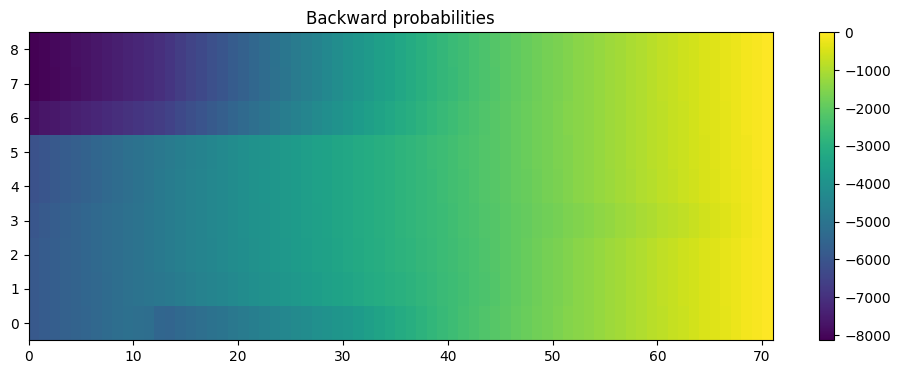

In [90]:
log_beta = backward(
    log_multivariate_normal_density_diag(
        example['lmfcc'], wordHMMs_one['o']['means'], wordHMMs_one['o']['covars']),
    np.log(wordHMMs_one['o']['startprob'])[:-1],
    np.log(wordHMMs_one['o']['transmat'][:-1, :-1])
)
plt.figure(figsize=(12, 4))
plt.pcolormesh(log_beta.T)
plt.yticks(np.arange(9) + 0.5, np.arange(9))
plt.colorbar()
plt.title("Backward probabilities")

assert np.allclose(log_beta, example['logbeta'])

In [91]:
def sequence_likelihood_backward(log_beta, log_start_probs):
    """
    Compute the sequence likelihood given the backward probabilities (log_beta).
    """
    return logsumexp(log_beta[0] + log_start_probs)

loglik_forward = sequence_likelihood_forward(log_alpha)
loglik_backward = sequence_likelihood_backward(log_beta, np.log(wordHMMs_one['o']['startprob'][:-1]))

example['loglik'], loglik_backward, loglik_forward

C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\3228901480.py:8: RuntimeWarning: divide by zero encountered in log
  loglik_backward = sequence_likelihood_backward(log_beta, np.log(wordHMMs_one['o']['startprob'][:-1]))


(-5970.427602563561, -5884.066355177513, -5970.427602563563)

## 6.1 State posterior probabilities

In [92]:
log_gamma = statePosteriors(log_alpha, log_beta)

# Check that the sum of the gamma is 1 for each time frame
assert np.allclose(np.sum(np.exp(log_gamma), axis=1), 1)

Text(0.5, 1.0, 'State posteriors probabilities')

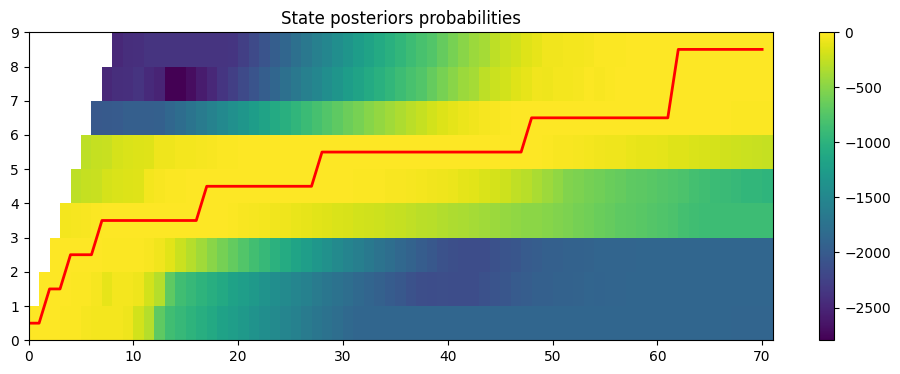

In [93]:
plt.figure(figsize=(12, 4))
plt.pcolormesh(log_gamma.T)
plt.colorbar()
plt.plot(viterbi_path+0.5, 'r', lw=2)
plt.title("State posteriors probabilities")

*Answer:* Compared to overlaying on the alpha log probabilities, we can see the the viterbi path denotes the path with the highest probability of the state sequence. 

Compare qualitatively the HMM and GMM posteriors. What is the difference? Why? What is the effect of the transition model in the HMM combined with the more complex way of computing the state posteriors?

In [94]:
from scipy.stats import multivariate_normal

def gmm_log_posteriors(x_seq, means, covars):
    N = means.shape[0]
    T = x_seq.shape[0]
    posteriors = np.zeros((T, N))
    for t in range(T):
        # We considor equal priors for all states, and no transition model
        numerator = np.array([multivariate_normal.pdf(x_seq[t], mean=means[i], cov=covars[i])/N for i in range(N)])
        denominator = np.sum(numerator)
        posteriors[t, :] = numerator / denominator
    return np.log(posteriors + 1e-10)

In [95]:
log_gmm = gmm_log_posteriors(example['lmfcc'], wordHMMs_one['o']['means'], wordHMMs_one['o']['covars'])

assert np.allclose(np.sum(np.exp(log_gmm), axis=1), 1)

Text(0.5, 1.0, 'GMM posteriors probabilities')

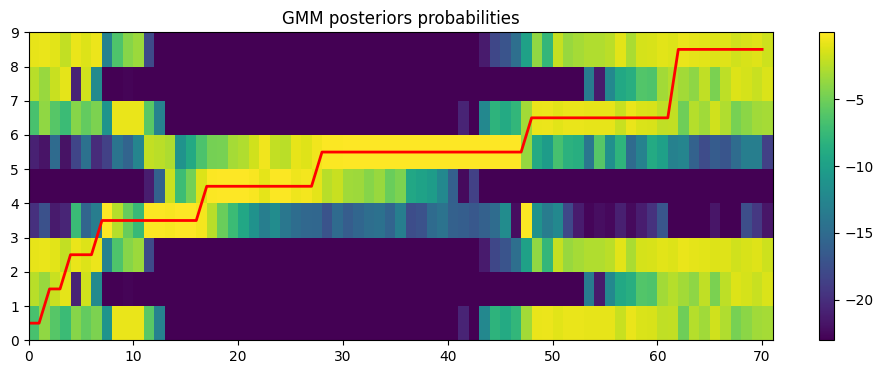

In [96]:
plt.figure(figsize=(12, 4))
plt.pcolormesh(log_gmm.T)
plt.colorbar()
plt.plot(viterbi_path+0.5, 'r', lw=2)
plt.title("GMM posteriors probabilities")

*Answer:* Compared the HMM posteriors, the transitions are not smooth, we see abrupt vertical color transitions. There is no structure.

That's normal as the GMM posteriors are local, they only use the current time step and they don't account for the transitions, nor the sequence, while the HMM posteriors account for the sequence and the transitions, which gives us structured horizontal bands.

The viterbi path still mostly go through the high probability states, but it sometimes cuts through the low probability states of the GMM posteriors, it aligns much less well with the high probability regions. 

Now sum the HMM posteriors (in linear domain) for each state along the time axis. What is the meaning the the values you obtain? What about summing over both states and time steps? Compare this number to the length of the observation sequence.

In [97]:
np.sum(np.exp(log_gamma), axis=0)

array([ 1.34597458,  2.09555994,  3.55849998,  9.73752276, 10.12040999,
       20.5329264 , 12.9968938 ,  1.20869929,  9.40351326])

*Answer:*: The values represent the expected number of times the state was active, so the expected number of time the HMM was in state i during the observation sequence, how much responsability it has in the observation sequence. It will serve as weights to update the model parameters in the Baum Welch Algorithm. 

In [98]:
# sum over both axis
np.sum(np.sum(np.exp(log_gamma), axis=1)), len(example['lmfcc'])

(71.00000000000345, 71)

*Answer:* The sum over both states and time steps is equal to the total number of time steps, as the sum over all the states of the posterior distribution is equal to 1. 

### 6.2 Retraining the emission probability distributions

In [99]:
model = wordHMMs_all['4']
utterance = data[10]

In [100]:
# Get all data where digit is 4
digit_4 = [u for u in data if u['digit'] == '4']
len(digit_4)

4

In [101]:
NB_ITERATIONS = 20
INCREASE_THRESHOLD = 1.0

In [102]:
def baum_welch_algorithm(utterance, model):
    loglik_list = []
    prev_loglik = -np.inf
    for i in range(NB_ITERATIONS):
        # Expectation step
        obsloglik = log_multivariate_normal_density_diag(utterance['lmfcc'], model['means'], model['covars'])
        log_alpha = forward(obsloglik, np.log(model['startprob'])[:-1], np.log(model['transmat'][:-1, :-1]))
        log_beta = backward(
            log_multivariate_normal_density_diag(
                utterance['lmfcc'], model['means'], model['covars']),
            np.log(model['startprob'])[:-1],
            np.log(model['transmat'][:-1, :-1])
        )
        log_gamma = statePosteriors(log_alpha, log_beta)
        
        # Maximization step
        model['means'], model['covars'] = updateMeanAndVar(utterance['lmfcc'], log_gamma)
        
        # Compute the log-likelihood of the sequence
        loglik = sequence_likelihood_forward(log_alpha)
        if loglik - prev_loglik < INCREASE_THRESHOLD:
            break
        prev_loglik = loglik
        loglik_list.append(loglik)
    return model, loglik_list

In [103]:
model, loglik_list = baum_welch_algorithm(utterance, model)

C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\1160790173.py:7: RuntimeWarning: divide by zero encountered in log
  log_alpha = forward(obsloglik, np.log(model['startprob'])[:-1], np.log(model['transmat'][:-1, :-1]))
C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\1160790173.py:11: RuntimeWarning: divide by zero encountered in log
  np.log(model['startprob'])[:-1],
C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\1160790173.py:12: RuntimeWarning: divide by zero encountered in log
  np.log(model['transmat'][:-1, :-1])


In [104]:
loglik_list

[-6826.654332902908,
 -6154.595775649376,
 -6022.524852217479,
 -5998.157284976034,
 -5994.049059721695]

In [105]:
bm_models = dict.fromkeys(wordHMMs_all.keys())
bm_loglik_list = dict.fromkeys(wordHMMs_all.keys())
for digit in wordHMMs_all.keys():
    bm_models[digit], bm_loglik_list[digit] = baum_welch_algorithm(digit_4[0], wordHMMs_all[digit])

C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\1160790173.py:7: RuntimeWarning: divide by zero encountered in log
  log_alpha = forward(obsloglik, np.log(model['startprob'])[:-1], np.log(model['transmat'][:-1, :-1]))
C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\1160790173.py:11: RuntimeWarning: divide by zero encountered in log
  np.log(model['startprob'])[:-1],
C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\1160790173.py:12: RuntimeWarning: divide by zero encountered in log
  np.log(model['transmat'][:-1, :-1])


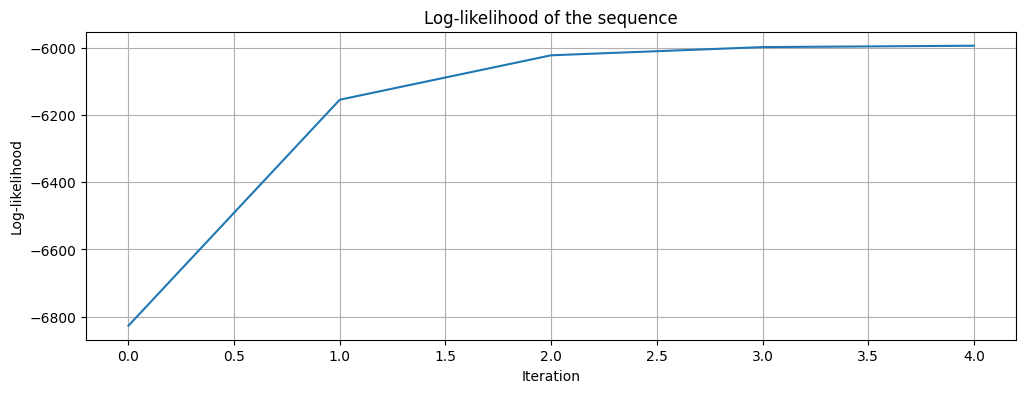

In [106]:
# Plot loglikelihood
plt.figure(figsize=(12, 4))
plt.plot(loglik_list)
plt.title("Log-likelihood of the sequence")
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.grid()
plt.show()

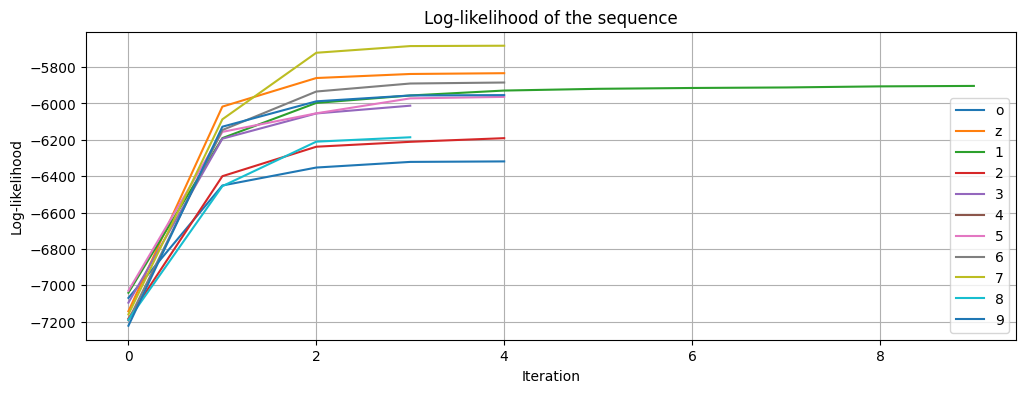

In [107]:
# Plot the log-likelihood of the sequence for each model
plt.figure(figsize=(12, 4))
for m in bm_loglik_list.keys():
    plt.plot(bm_loglik_list[m], label=m)
plt.title("Log-likelihood of the sequence")
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def score_utterrances(data, wordHMMs):
    """
    Compute the log-likelihood of each utterance in data given the wordHMMs.
    """
    scores = []
    for i in tqdm(range(len(data))):
        for h in wordHMMs.keys():
            obsloglik = log_multivariate_normal_density_diag(data[i]['lmfcc'], wordHMMs[h]['means'], wordHMMs[h]['covars'])
            log_alpha = forward(obsloglik, np.log(wordHMMs[h]['startprob'])[:-1], np.log(wordHMMs[h]['transmat'][:-1, :-1]))
            scores.append(sequence_likelihood_forward(log_alpha))
    return np.array(scores).reshape(len(data), len(wordHMMs))

In [128]:
def max_lik_pred(lik, wordHMMs):
    """
    Predict the digit for each utterance in data using the maximum likelihood criterion.
    """
    pred = np.argmax(lik, axis=0)
    return [list(wordHMMs.keys())[i] for i in pred]

In [129]:
lik_viterbi = score_utterrances_viterbi(digit_4, bm_models)

  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\celin_e3kjw6h\AppData\Local\Temp\ipykernel_16344\4025665117.py:9: RuntimeWarning: divide by zero encountered in log
  log_V, viterbi_path = viterbi(obsloglik, np.log(wordHMMs[h]['startprob'])[:-1], np.log(wordHMMs[h]['transmat'][:-1, :-1]), forceFinalState=True)
100%|██████████| 4/4 [00:00<00:00,  9.59it/s]


In [130]:
pred_viterbi = max_lik_pred(lik_viterbi, wordHMMs_all)

In [133]:
len(pred_viterbi), len(digit_4)

(11, 4)

In [134]:
def accuracy(pred):
    """
    Compute the accuracy of the predictions.
    """
    defects = []
    correct = 0
    for i in range(len(pred)):
        print(pred[i])
        if pred[i] == "4":
            correct += 1
        else:
            defects.append(pred[i])
    return correct / len(data), defects

In [136]:
acc_viterbi, defects_viterbi_all = accuracy(pred_viterbi)

o
o
o
o
o
o
o
o
o
o
o
